In [2]:
from filmModels import *
from dataPreprocess import *
from filmPostProcess import *
import os

In [4]:
# set parameters

label = 'materials'
tab_params = ['proj_x_norm', 'proj_y_norm', 'depth_norm', 'interval_length_norm', 'year_norm', 'month_cyclic_norm']
label_predict = label + '_code'

film=True
restrict_to_hds = False
seed = 'kfold' # 'kfold', -1 for random, or other positive numbers for seed for train-test split

chip_size = 128
train_max_epoch = 10
max_iterations = 5
batch_size = 20
print_train_progress = True
print_test_model = True
hidden_width=32 
hidden_nblocks=4
L2_param = 1e-5

train_test_ratio = 0.7


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# path of csv containing tabular data
bh_file_path = 'data_stephen_fix_header.csv'

chips_path = r'C:\Users\mouju\Desktop\film\raster_chips\concat_geo90_arcticdem'

# chips_path = r'C:\Users\mouju\Desktop\film\raster_chips\concat_80bh_hdslanczos_34_128_128'

meta_params = {'chip_size': chip_size,
               'train_max_epoch': train_max_epoch,
               'max_iterations': max_iterations, 
               'batch_size': batch_size,
               'print_train_progress': print_train_progress,
               'print_test_model':print_test_model,
               'device':device,
               'hidden_width': hidden_width,
               'hidden_nblocks':hidden_nblocks,
               'L2_param':L2_param,
               'film':film, 
               'seed':seed, 
               'train_test_ratio': train_test_ratio, 
               'restrict_to_hds':restrict_to_hds}

In [5]:
# preprocessing data

# list of columns in the dataframe to normalize
list_cols = ['latitude', 'longitude', 'proj_x', 'proj_y', 'depth', 'interval_length', 'time']

df = pd.read_csv(bh_file_path, header=[0])
df, n_classes = prepare_df(df, list_cols, label)
print(f'Number of classes is : {n_classes}')

Dataframe has length 2837
Number of unique boreholes is 566
Latitude ranges from 68.36933 to 69.44755
Longitude ranges from -133.82843 to -132.89346
List of columns normalized: ['latitude_norm', 'longitude_norm', 'proj_x_norm', 'proj_y_norm', 'depth_norm', 'interval_length_norm', 'year_norm', 'month_cyclic_norm']
visible_ice: 'None' entries have been replaced by 'No visible ice'
visible_ice column entries has been ordered:
[NaN, 'Pure ice', 'No visible ice', 'High', 'Medium to high', 'Low']
Categories (5, object): ['No visible ice' < 'Low' < 'Medium to high' < 'High' < 'Pure ice']
with corresponding codes in visible_ice_code column:
[-1  4  0  3  2  1]
visible_ice: binary column generated
materials: 'ICE' and 'ice' entries has been standardized into 'Ice'
'material_ice' column generated
materials has been categorized into codes in materials_code
Null entries of materials dropped
Number of classes is : 12


In [6]:
    df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)
    
    df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
    df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
    df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
    df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)
    
    df['materials'].replace(['Till'], 'Sand', regex=True, inplace=True)
    df['materials'].replace(['Silt'], 'Sand', regex=True, inplace=True)
    
    df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)

In [7]:
df

,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,...,proj_x_norm,proj_y_norm,depth_norm,interval_length_norm,year_norm,month_cyclic_norm,visible_ice_code,visible_ice_binary,material_ice,materials_code
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.15,0,NaN,NaN,TOPSOIL,Organics,...,1.445622,-1.848974,-1.024190,-0.814423,-1.164992,-1.225295,-1,1,0,6
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,...,1.445622,-1.848974,-0.835900,-0.347622,-1.164992,-1.225295,4,1,1,5
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Sand,...,1.445622,-1.848974,-0.553466,-0.405972,-1.164992,-1.225295,0,0,0,1
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Sand,...,1.445622,-1.848974,0.387982,2.511531,-1.164992,-1.225295,0,0,0,1
4,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Sand,...,1.443401,-1.839824,-0.741756,0.410929,-1.164992,-1.225295,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,5.45,1,Nf/Nbn,No visible ice,NaN,Sand,...,-1.497028,0.887109,0.401431,2.219781,-0.319053,0.736422,0,0,0,11
2833,68.38262,-133.71211,2013-04-27T00:00:00Z,W14103137-S6-BH15,8.65,1,Nbn,No visible ice,NaN,Sand,...,-1.497028,0.887109,1.262184,-0.464322,-0.319053,0.736422,0,0,0,11
2834,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.05,0,NaN,No visible ice,ORGANICS,Organics,...,-1.492299,0.875448,-1.051089,-0.931123,-0.319053,0.736422,0,0,0,6
2835,68.38386,-133.70967,2013-04-27T00:00:00Z,W14103137-S6-BH16,0.35,0,NaN,No visible ice,NaN,Sand,...,-1.492299,0.875448,-0.970393,-0.697722,-0.319053,0.736422,0,0,0,11


In [ ]:
# 7 even classes of material
# df['materials'].replace(['Pure Ice'], 'Ice', regex=True, inplace=True)
    
#     df['materials'].replace(['Coarse till'], 'Till', regex=True, inplace=True)
#     df['materials'].replace(['till'], 'Till', regex=True, inplace=True)
#     df['materials'].replace(['Fine till'], 'Till', regex=True, inplace=True)
#     df['materials'].replace(['Fine Till'], 'Till', regex=True, inplace=True)
    
#     df['materials'].replace(['Cobbles'], 'Gravel', regex=True, inplace=True)
#     df['materials'].replace(['Rock'], 'Gravel', regex=True, inplace=True)

In [5]:
df.materials.unique()

['Organics', 'Ice', 'Sand', 'Gravel', 'Clay', 'Rock']
Categories (6, object): ['Organics', 'Ice', 'Sand', 'Gravel', 'Clay', 'Rock']

In [12]:
sum(df.materials=='Rock')

11

In [8]:
sum(df.visible_ice_binary==1)

1881

In [4]:
if meta_params['restrict_to_hds']:
    n_bh_temp = len(df)
    df = crop_hds_discard_chips(df)
    print(f'Number of boreholes has decreased from {n_bh_temp} to {len(df)}')
else:
    n_bh_temp = len(df)
    df = df.query("borehole != 'ENG.YARC03097-01--HUS_H (NTGS 7)'")
    df = df.query("borehole != 'W14103137-CR4N'")
    df = df.query("borehole != 'W14103137-S6-BH15'")
    df = df.query("borehole != 'W14103137-S6-BH14'")
    df = df.query("borehole != 'W14103137-S6-BH16'")
    print(f'Number of boreholes has decreased from {n_bh_temp} to {len(df)}')

Number of boreholes has decreased from 2752 to 2716


In [5]:
# create custom data for film
loaded_dataset = filmDataset(chips_path, df, tab_params, label_predict, chip_size)

meta_params['n_channels'] = loaded_dataset.n_channels
meta_params['n_classes'] = n_classes
if n_classes == 1:
    meta_params['loss_fn'] = torch.nn.BCELoss()
else:
    meta_params['loss_fn'] = torch.nn.CrossEntropyLoss()
meta_params['full_dataset'] = loaded_dataset

Dataset contains 28 channels


In [6]:
# Record and average accuracies from multiple models
if seed == 'kfold':
    results, certainties = iterate_kfold(meta_params, loaded_dataset)
else:
    results, certainties = iterate(meta_params, loaded_dataset)

FOLD 0
--------------------------------


c:\users\mouju\appdata\local\programs\python\python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch  1: running loss: 1.42683, validation loss: 1.41349
epoch  2: running loss: 1.38866, validation loss: 1.35193
epoch  3: running loss: 1.35770, validation loss: 1.37270
epoch  4: running loss: 1.35094, validation loss: 1.34266
epoch  5: running loss: 1.34239, validation loss: 1.35558
epoch  6: running loss: 1.32608, validation loss: 1.34375
epoch  7: running loss: 1.32089, validation loss: 1.37438
epoch  8: running loss: 1.32207, validation loss: 1.35184
epoch  9: running loss: 1.30731, validation loss: 1.33263
epoch 10: running loss: 1.29587, validation loss: 1.36250
Finished Training
epoch 9 model selected
Before temperature - NLL: 1.275, ECE: 0.030
Optimal temperature: 1.459
After temperature - NLL: 1.309, ECE: 0.084
(array([0.41452991, 0.38064516, 0.41935484, 0.        , 0.        ]), array([0.53005464, 0.41258741, 0.40625   , 0.        , 0.        ]), array([0.46522782, 0.39597315, 0.41269841, 0.        , 0.        ]), array([183, 143, 160,  13,  45], dtype=int64))
iteration 

In [7]:
display_results(meta_params, results)

mean


,precision,recall,f1,support
0,0.417198,0.613936,0.496074,188.6
1,0.399098,0.242983,0.283985,143.2
2,0.368537,0.442396,0.397213,145.4
3,0.000000,0.000000,0.000000,14.0
4,0.000000,0.000000,0.000000,52.0


std


,precision,recall,f1,support
0,0.026586,0.048631,0.030355,5.161395
1,0.013690,0.113382,0.088776,7.756288
2,0.049494,0.105291,0.060065,13.139254
3,0.000000,0.000000,0.000000,1.897367
4,0.000000,0.000000,0.000000,7.071068


Accuracy mean: 0.39764042357274404, std: 0.021572438248359495


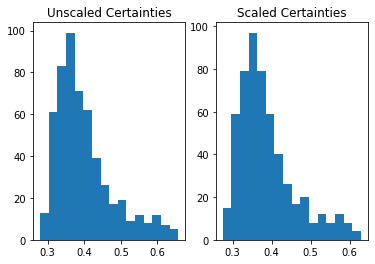

In [8]:
certainties_histogram(certainties)